
Datum: 13.11.2022
Autor: Jonas Engler
Zuletzt geändert: 13.11.2022

TODO:
- lineare Regression als Anwendungsfall betrachten, siehe Buch

Aufgaben:
- Outlier-detektion:  Welche Dateien sind auffällig? Sind es die mit wenig acc-Daten
- Korrelationsbetrachtung:
    - Für die Noiseklassen
- Peakdetektion

Ablauf:
Outlierdetektion:
1. Laden der Daten als Liste
2. Für jede Dimension die Faktoren darstellen
3. Die Untersten 5 in jeder Dimension holen und vergleichen
4. manueller Abgleich mit Datenbasis

Korrelationsbetrachtung:
1. Die Daten in der Noisedimension als Scatter-Plot als Subplot darstellen
2. Pearsonkorrelationskoeffizienten darstellen, sowie andere Maße
3. Best-fit-line berechnen und darstellen
4. Tornadoplot der Diagramme

Peakdetektion
1. Darstellung der verschiedenen Kurven

In [17]:
import numpy as np # used for numeric calculation
import matplotlib.pyplot as plt # used for plotting
import os # used for loading data
from scipy.signal import find_peaks # for finding peaks in data
from scipy.stats import pearsonr # for calculating pearsonr
from math import ceil
from matplotlib.lines import Line2D # for creating legends for data
from scipy.optimize import curve_fit # for creating nonlinear regression models

In [18]:
# load filenames
files = [file for file in os.listdir("./") if file.endswith(".npy")]
# load as .npy binary format, one file contains an array of the form [[Names of Base-Noise-Audio Pairs],[[Name of Dims],[Dim-Coordinates]],[Confidence Values]]
data = np.array([np.load(file, allow_pickle=True) for file in files])
n = data.shape[0] # get number of files

# used for evaluating the pitch shift dimension
# loads an file containing the average fft of test data
csv_data = "./fft_average_peak_0.csv"
if os.path.exists(csv_data):
    with open(csv_data) as stream:
        # remove header of file
        next(stream)
        csv_data= np.array([list(map(float, line.split(','))) for line in stream])

# general variables used throughout the code
fontsize= 12 # fontsize of text in figures
path = "" # save path
saveFigs = False # save figures to disk if nessecary
sr = 22050 # sampling rate used for evaluation

In [19]:
# gets the n lowest values of a list, returns the indexs of those
# used for debugging and finding faulty files
def lowest_values(arr,n=5):
    """
    arr: array to ireate sequentially over
    n: how many lowest numbers to find
    """
    
    comp_arr = [(arr[i],i) for i in range(n)]
    comp_arr = sorted(comp_arr) # temporary array for saving files
    
    # iterate over list, check values and fill comp_arr
    for i in range(len(arr)):
        if arr[i] < comp_arr[-1][0]: # if value is smaller than the smallest
            #insert at right place
            for j in range(len(comp_arr)):
                # if place index found, insert and delete last element
                if arr[i] < comp_arr[j][0]:
                    comp_arr.insert(j,(arr[i],i))
                    comp_arr = comp_arr[:-1]
                    break
    return [val_tup[1] for val_tup in comp_arr]

# used for calculating the r2-Value of predictor function
def r2_value(x,y,p):
    """
    x: x values, independent variable ; should be passed as numpy array
    y: y values, actualy values, dependent variable ; should be passed as numpy array
    p: predictor function that can be called p(x) on a value x ; can be passed as lambda expression
    """
    # calculate the r2-Value r2 = 1- sum((y-yhat)**2)/sum((y-ymean)**2) 
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((y-yhat)**2)
    sstot = np.sum((y-ybar)**2)
    
    return 1-ssreg/sstot
    

In [14]:
# take a look at the values if nessecary
#print(np.array(data[0][0]))
#print(np.array(data[0][1]))
#print(np.array(data[0][2]))

In [20]:
# -----
# Data processing - start this first, then cells below
# -----
#check audio files

# filter low values, so that they wont affect analysis
filter_low_values = True
conf_border = 0.6 # the border at which values lower thant this are filtered
print_num_deletedValues = False # print the number of deleted values

# values
pred_values = [] # used for containing processed evaluations
# create array with dimension values so that it takes ordered form [[dim1],[dim2],[dim3]]
# data[0][1][1] are the modification values (stellwerte) that are a list of tuples that for (fictional) example take the form  
# (0,0,0), (0,0,1),..(0,0,9), (0,1,0)..,(0,9,9),(1,0,0)
# len(data[0][1][1][0]) is the number of columns or rather modification dimensions
# [ dim[i] for dim in data[0][1][1] ] go trough column and get all unique values
dims = [ sorted(set( [ dim[i] for dim in data[0][1][1] ] )) for i in range(len(data[0][1][1][0]))]


# Shape of x [[Names of Base-Noise-Audio Pairs],[[Name of Dims],[Dim-Coordinates]],[Confidence Values]]
# look at all files and create list of evaluations
for i,x in enumerate(data):
    # get temporary dimension
    temp_dim = np.array(x[1][1])
    
    # get indexes of dims ; np.where ( list bools&list bools) returns indexs of nonzero values
    # if evaluation is matrix that takes form (n,#d1,#d2,#d3) then one of the dn arrays
    # applies to the to (#d1,#d2,#d3)
    d1 = np.where((temp_dim[:,1]==0) & (temp_dim[:,2]==0)) # second and last dimension are zero
    d2 = np.where((temp_dim[:,0]==0) & (temp_dim[:,2]==0)) # first and last are zero
    d3 = np.where((temp_dim[:,0]==0) & (temp_dim[:,1]==0)) # first and second are zero
    
    # get evaluation values ; x[2] is a matrix of the form (#base audio*noise audio, #d1, #d2, #d3)
    # go through dim (#base audio*#noise audio) and unravel data so evaluation can be extracted
    # with truth array dn
    d1_v = np.array([ space.ravel()[d1] for space in x[2] ]) # unravel go trough eval spaces, unravel data and extract
    d2_v = np.array([ space.ravel()[d2] for space in x[2] ])
    d3_v = np.array([ space.ravel()[d3] for space in x[2] ])
    
    
    if filter_low_values:        
        if print_num_deletedValues: # if values have been printed, regular deletion can be continued
            # get indexes of unmodified values below threshhold to eliminate faulty files
            cond_values = (d1_v[:,0]<conf_border).nonzero() # get values that are not 0 i.e. False
            # delete from array
            d1_v = np.delete(d1_v,cond_values,0)
            cond_values = (d2_v[:,int(d2_v.shape[1]/2)]<conf_border).nonzero() # get values that are not 0 i.e. False
            d2_v = np.delete(d2_v,cond_values,0)
            cond_values = (d3_v[:,0]<conf_border).nonzero() # get values that are not 0 i.e. False
            d3_v = np.delete(d3_v,cond_values,0)
        else: # if values have not been printed
            cond_values = (d1_v[:,0]<conf_border).nonzero() # get values that are not 0 i.e. False
            print(f"Von {len(d1_v[:,0])} Werten wurden {len(cond_values[0])} gefiltert")
            d1_v = np.delete(d1_v,cond_values,0)
            cond_values = (d2_v[:,int(d2_v.shape[1]/2)]<conf_border).nonzero() # get values that are not 0 i.e. False
            print(f"Von {len(d2_v[:,0])} Werten wurden {len(cond_values[0])} gefiltert")
            d2_v = np.delete(d2_v,cond_values,0)
            cond_values = (d3_v[:,0]<conf_border).nonzero() # get values that are not 0 i.e. False
            print(f"Von {len(d3_v[:,0])} Werten wurden {len(cond_values[0])} gefiltert")
            d3_v = np.delete(d3_v,cond_values,0)
        
    # save processed values for later use
    pred_values.append([d1_v,d2_v,d3_v])

Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert
Von 10100 Werten wurden 1000 gefiltert


xp_total:  [0.  0.1 0.2 ... 0.8 0.9 1. ]
Isoclip
r2 value: 0.1302
x1:  -0.4655  ,x2:  0.8672

xp_total:  [0.  0.1 0.2 ... 0.8 0.9 1. ]
iso_clip_rascheln
r2 value: 0.2814
x1:  -0.7499  ,x2:  0.8588

xp_total:  [0.  0.1 0.2 ... 0.8 0.9 1. ]
Klatschen
r2 value: 0.2779
x1:  -0.7186  ,x2:  0.9124

xp_total:  [0.  0.1 0.2 ... 0.8 0.9 1. ]
Schmelzabdeckung
r2 value: 0.1235
x1:  -0.3733  ,x2:  0.9267

xp_total:  [0.  0.1 0.2 ... 0.8 0.9 1. ]
Schrauber
r2 value: 0.0587
x1:  -0.172  ,x2:  0.9608



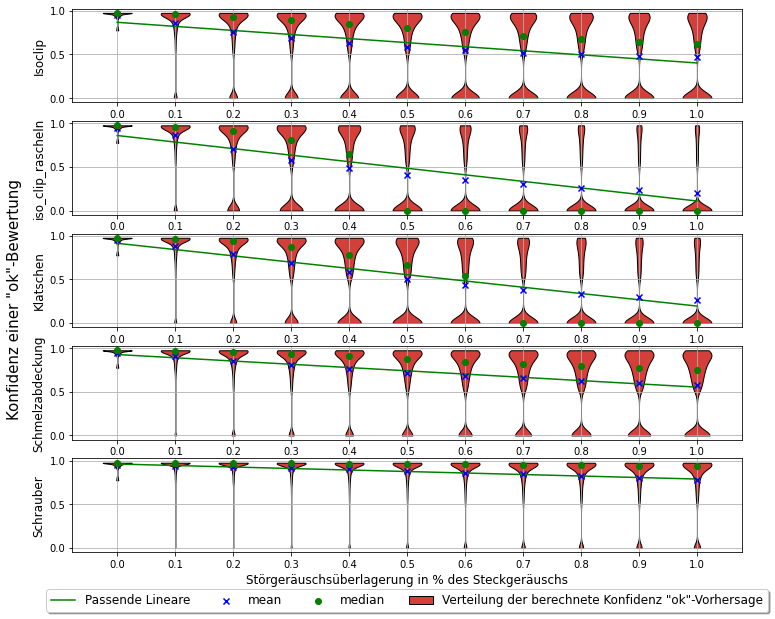

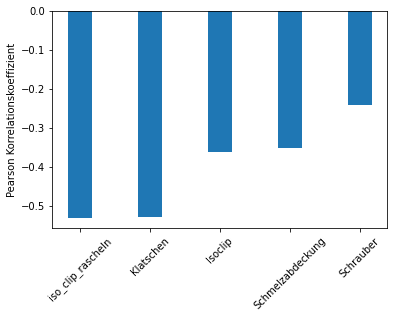

In [24]:
# -------------
# Noiseinjection
# -------------

# note
# ravel() - unravels data to a 1d array



fig1,axs = plt.subplots(n,1, figsize=(12, 10))
# set label of axis to last dimension
axs[-1].set_xlabel(data[0][1][0][-1], fontsize=12)


# iterate over evaluations of files and plot them into subplot
for i,x in enumerate(pred_values):
    # calculate the mean and median
    pred_mean = np.array([np.mean(pred_values[i][2][:,j]) for j in range(pred_values[i][2].shape[-1])])
    pred_median = np.array([np.median(pred_values[i][2][:,j]) for j in range(pred_values[i][2].shape[-1])])
    # generate x data for poly fit ; * operator repeats array n times
    xp_total = np.array(dims[2]*pred_values[i][2].shape[0])
    a,b = np.polyfit(xp_total,pred_values[i][2].ravel(),1) # a is an ndarray of the polynmials and b the zero polynimial, atleast for functions of degree 1
    
    # set file name as ylabel
    _=axs[i].set_ylabel(files[i].replace("predictions_",'').replace(".npy",''), fontsize=fontsize) 
    
    # due to violinplot using the positions 1,2,3,...,n extra positions need to be generated
    xp = np.arange(1,len(dims[2])+1)
    axs[i].plot(xp,a*np.array(dims[2])+b,c='green',zorder=8) # plot the poly-fit-line in green
    axs[i].scatter(xp,pred_mean,c='blue', marker='x',zorder=9) # plot mean of samples for each x-value in red
    axs[i].scatter(xp,pred_median,c='green', marker='o',zorder=10) # plot mean of samples for each x-value in red

    # calculate r2-value 
    r2 = r2_value(xp_total, pred_values[i][2].ravel(), lambda x : x*a+b)
    print(files[i].replace("predictions_",'').replace(".npy",''))
    print("r2 value:", round(r2,4))
    print("x1: ", round(a,4)," ,x2: ", round(b,4))
    print("")
    
    # extract violin data and plot it
    violin_data = []
    for j in range(pred_values[i][2].shape[-1]):
        violin_data.append(x[2][:,j])
        
    parts = axs[i].violinplot(violin_data, showmeans=False, showmedians=False,
        showextrema=False)
        
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    # generate xlabels
    _=axs[i].set_xticks(np.arange(1,len(dims[2])+1), labels=dims[2])
    
    # turn on grid
    axs[i].grid(True)
    
    



# Put a legend below current axis
plt.legend(["Passende Lineare", "mean","median","Verteilung der berechnete Konfidenz \"ok\"-Vorhersage"],loc='lower center', bbox_to_anchor=(0.5, -0.7),
          shadow=True, ncol=5,fontsize=fontsize)
# set Annotation for yaxis
axs[int(ceil(len(axs)/2))].annotate("Konfidenz einer \"ok\"-Bewertung", (-0.03,1.5), xytext=(-30, 0),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='right', va='center', size=15, rotation=90)
# save if nessecary
if saveFigs:
    plt.savefig(path+"noiseInjection.svg",format="svg",bbox_inches="tight")

# depict correlation coefficients/r2-value
fig2 = plt.figure()
# calculate correlation coefficients
coef_vals = []
for i,x in enumerate(pred_values):
    coef,_ = pearsonr(dims[2]*pred_values[i][2].shape[0],pred_values[i][2].ravel())
    coef_vals.append(coef)

# sorted correlation coeficients
temp = sorted([(x,i) for i,x in enumerate(coef_vals)], key=lambda tup: tup[0])
x = np.arange(len(coef_vals))
plt.bar(x,[val for val,i in temp],width=0.35) # plot them
plt.ylabel("Pearson Korrelationskoeffizient")
plt.xticks(x, [files[i].replace("predictions_",'').replace(".npy",'') for x,i in temp], rotation=45.0)

#save if nessecary
if saveFigs:
    plt.savefig(path+"Pearson.svg",format="svg",bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

Range: 4410.0-6615.0
Range: 15435.0-17640.0

original Confidence Value:  0.9482909
6615.0 0.37326857
17640.0 0.20581946


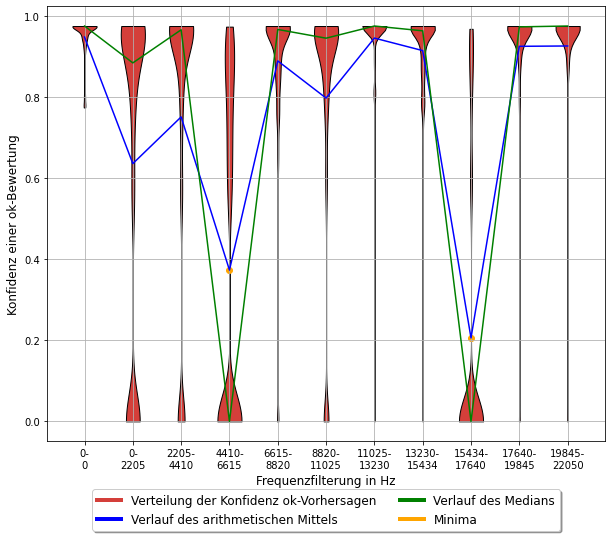

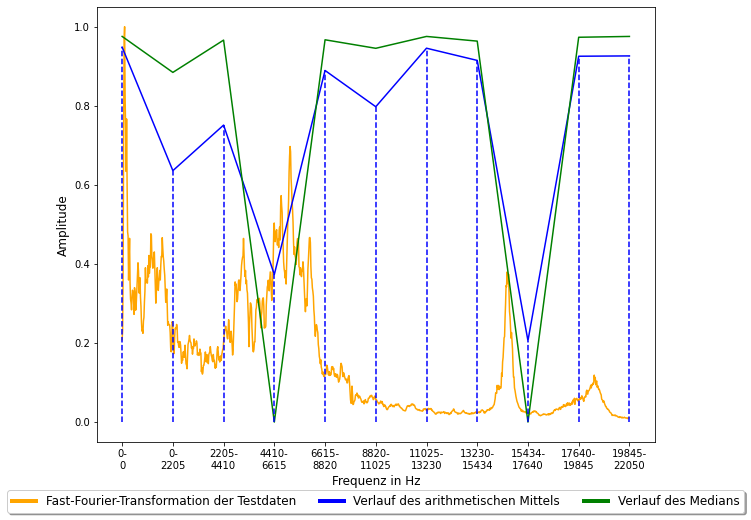

In [27]:
# -----------------
# Frequenzfilterung
# ----------------

# depict the frequency filtering    
plt.figure(figsize=(10,8))
# the pred_values[0] get the first element or any other, because all share the same values for this
# pred_values[0][0] means that we get the first dimension and [:,j] means for each column of the matrix
# or rather for each x-value, because each column represents an x-value
# calculate mean, median
pred_mean = np.array([np.mean(pred_values[0][0][:,j]) for j in range(pred_values[0][0].shape[-1])])
pred_median = np.array([np.median(pred_values[0][0][:,j]) for j in range(pred_values[0][0].shape[-1])])
# invert data and findpeaks to find minimum
temp = -1*pred_mean+np.mean(pred_mean)
peaks, _ = find_peaks(temp,height=max(temp)*0.6)


# plot violin plot of distribution
violin_data = []
for j in range(pred_values[0][0].shape[1]):
       violin_data.append(pred_values[0][0][:,j])

parts = plt.violinplot(violin_data, showmeans=False, showmedians=False,
        showextrema=False)
for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
# generate xlabels
x_labels = (np.array(dims[0])*sr).astype(int).astype(str).tolist()
x_labels = [f"{x_labels[i-1]}-\n{x_labels[i]}" if i>0 else f"{0}-\n{0}"  for i in range(len(x_labels))]

_=plt.xticks(np.arange(1,len(dims[0])+1), labels=x_labels)
plt.grid(True)

# output the intervals which are the peaks
for x in peaks:
    print(f"Range: {round(dims[0][x-1]*sr,2)}-{round(dims[0][x]*sr,2)}")

xp  = np.arange(1,len(dims[0])+1)

plt.scatter(xp[peaks],pred_mean[peaks],c='orange') 
plt.plot(xp,pred_mean,c='blue')
plt.plot(xp,pred_median,c='green')

print("\noriginal Confidence Value: ", pred_mean[0])
# print confidence values
for x in peaks:
    print(np.array(dims[0])[x]*sr, pred_mean[x])


# plot labels
plt.xlabel("Frequenzfilterung in Hz",fontsize=fontsize)
_=plt.ylabel("Konfidenz einer ok-Bewertung",fontsize=fontsize)


# Put a legend below current axis
custom_lines = [Line2D([0], [0], color='#D43F3A', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4)
               ]
# create legend
plt.legend(custom_lines, ['Verteilung der Konfidenz ok-Vorhersagen', 'Verlauf des arithmetischen Mittels', "Verlauf des Medians", "Minima"],loc='lower center', bbox_to_anchor=(0.5, -0.22),
          shadow=True, ncol=2,fontsize=fontsize)

if saveFigs:
    plt.savefig(path+"Frequenzfilterung.svg",format="svg",bbox_inches="tight")
    
plt.figure(figsize=(10,8))
plt.plot(csv_data[:,0],csv_data[:,1]/csv_data[:,1].max(),c='orange')
plt.plot(np.array(dims[0])*sr,pred_mean,c='blue')
plt.plot(np.array(dims[0])*sr,pred_median,c='green')
plt.vlines(np.array(dims[0])*sr,ymin=0,ymax=pred_mean, colors='blue',linestyles='dashed')

_=plt.xticks(np.array(dims[0])*sr, labels=x_labels)
plt.ylabel("Amplitude",fontsize=fontsize)
plt.xlabel("Frequenz in Hz", fontsize=fontsize)

custom_lines = [Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4),
               Line2D([0], [0], color='green', lw=4)]

plt.legend(custom_lines, ['Fast-Fourier-Transformation der Testdaten', 'Verlauf des arithmetischen Mittels', "Verlauf des Medians"],loc='lower center', bbox_to_anchor=(0.5, -0.177),
          shadow=True, ncol=5,fontsize=fontsize)

if saveFigs:
    plt.savefig(path+"FFT.svg",format="svg",bbox_inches="tight")

Lineare, x^1: 0.05063487651664475  x^0:  0.9677142419896039
e-Funktion:  [ 0.51156022  3.35761901 -0.01316483  0.43673976]
r2_l:  0.18277730447785778
r2_u:  0.16298508118556554


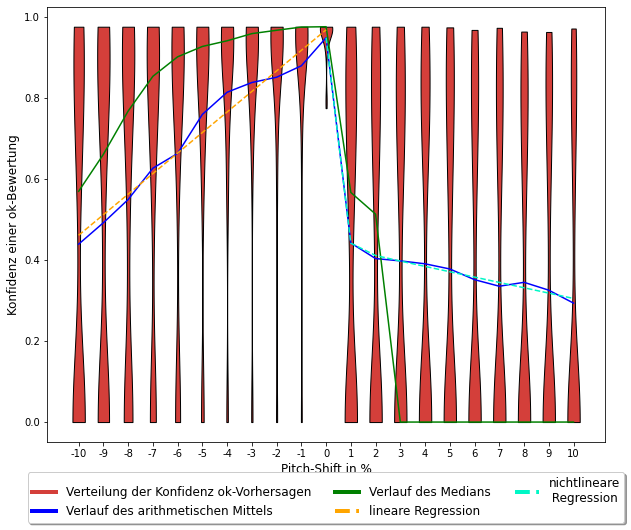

In [20]:
#--------------
# Pitchshift
#--------------

plt.figure(figsize=(10,8))
pred_mean = np.array([np.mean(pred_values[0][1][:,j]) for j in range(pred_values[0][1].shape[-1])])
pred_median = np.array([np.median(pred_values[0][1][:,j]) for j in range(pred_values[0][1].shape[-1])])

violin_data = []
for j in range(pred_values[0][1].shape[1]):
       violin_data.append(pred_values[0][1][:,j])

parts = plt.violinplot(violin_data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

#sns.violinplot(data=violin_data, scale="count", split=True,cut=0,color='#d13f34')

plt.xticks(np.arange(1,len(dims[1])+1), labels=np.array(dims[1]).astype(int))        



xp = np.arange(1,len(dims[1])+1)
plt.plot(xp,pred_mean,c='blue')
plt.plot(xp,pred_median,c='green')

plt.xlabel("Pitch-Shift in %",fontsize=fontsize)
_=plt.ylabel("Konfidenz einer ok-Bewertung",fontsize=fontsize)
 
# calculate the index to extract data for lower frequency shift
nl = int(len(dims[1])/2)+1
xl = np.array(dims[1])[:nl]
yl = pred_values[0][1][:,:nl]

# used polyfit to create linear function
xl = np.tile(xl,yl.shape[0])
al,bl = np.polyfit(xl,yl.ravel(),1) # a is an ndarray of the polynmials and b the zero polynimial, atleast for functions of degree 1

# calculate index to eextract data for upper frequency shift
nu = int(len(dims[1])/2)
xu = (np.array(dims[1])[nu:])
yu = pred_values[0][1][:,nu:]
xu = np.tile(xu,yu.shape[0])

# separate function instead of passing a polnomial
def function(x, a, b, c, d):
    return a*np.exp(-b*x)+c*x+d
    #return a*(1/10)**x+c
# calculate optimal parameters
popt, pcov = curve_fit(function, xu, yu.ravel())

# plot the result
plt.plot(xp[:nl],al*np.array(dims[1][:nl])+bl, c="orange", linestyle='--')
plt.plot(xp[nu:], function(np.array(dims[1][nu:]), *popt), c='#00f7c6', linestyle='--')


custom_lines = [Line2D([0], [0], color='#D43F3A', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4, linestyle='--'),
                Line2D([0], [0], color='#00f7c6', lw=4, linestyle='--')
               ]

plt.legend(custom_lines, ['Verteilung der Konfidenz ok-Vorhersagen', 'Verlauf des arithmetischen Mittels', "Verlauf des Medians", 'lineare Regression', "nichtlineare\n Regression"]
           ,loc='lower center', bbox_to_anchor=(0.5, -0.2),
          shadow=True, ncol=3,fontsize=fontsize)


r2_l = r2_value(xl,yl.ravel(), lambda x : al*x+bl)
r2_u = r2_value(xu,yu.ravel(), lambda x : function(x, *popt))

# print r2-values
print("Lineare, x^1:",al," x^0: ",bl)
print("e-Funktion: ",popt)
print("r2_l: ",r2_l)
print("r2_u: ",r2_u)
if saveFigs:
    plt.savefig(path+"PitchShift.svg",format="svg",bbox_inches="tight")
